In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.metrics import MeanAbsoluteError, MeanSquaredError, MeanAbsolutePercentageError
import tensorflow.keras.backend as K
import joblib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.optimizers import Nadam


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import joblib
import keras
from keras import backend as K
from keras.optimizers import Nadam
from keras.callbacks import EarlyStopping, ModelCheckpoint

def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def r2_score(y_true, y_pred):
    SS_res = K.sum(K.square(y_true - y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return 1 - (SS_res / (SS_tot + K.epsilon()))

nadam_opt = Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7)

archivos = {
    "Humedad": "/content/drive/MyDrive/SIC Proyecto/humedad(2010-2022).csv",
    "Irradiacion": "/content/drive/MyDrive/SIC Proyecto/Irradiacion(2010-2022).csv",
    "Lluvia": "/content/drive/MyDrive/SIC Proyecto/lluvia(2010-2022).csv",
    "Skintemp": "/content/drive/MyDrive/SIC Proyecto/skintemp(2010-2022).csv",
    "Temp2m": "/content/drive/MyDrive/SIC Proyecto/Temp2m(2010-2022).csv",
    "Viento": "/content/drive/MyDrive/SIC Proyecto/viento(2010-2022).csv"
}

meses = ["JAN", "FEB", "MAR", "APR", "MAY", "JUN", "JUL", "AUG", "SEP", "OCT", "NOV", "DEC"]

dfs = []
for nombre, path in archivos.items():
    df = pd.read_csv(path)
    df = df.melt(id_vars=["PARAMETER", "YEAR", "LAT", "LON"], value_vars=meses, var_name="Mes", value_name=nombre)
    df.rename(columns={"YEAR": "Año", "LAT": "Latitud", "LON": "Longitud"}, inplace=True)
    df.drop("PARAMETER", axis=1, inplace=True)
    dfs.append(df)

df_final = dfs[0]
for df in dfs[1:]:
    df_final = df_final.merge(df, on=["Latitud", "Longitud", "Año", "Mes"], how="inner")
    df_final

In [ ]:
df_final.head()

,Año,Latitud,Longitud,Mes,Humedad,Irradiacion,Lluvia,Skintemp,Temp2m,Viento
0,2010,18.75,-95.75,JAN,83.89,10.80,2.11,20.32,19.90,3.48
1,2010,18.75,-96.25,JAN,81.44,11.53,0.00,19.30,19.15,2.43
2,2010,18.75,-96.75,JAN,82.71,11.53,0.00,14.81,14.84,1.28
3,2010,18.75,-97.25,JAN,79.28,14.87,0.00,11.91,11.59,2.07
4,2010,18.75,-97.75,JAN,71.48,14.87,0.00,12.10,11.65,2.61


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import joblib
import keras
from keras import backend as K
from keras.optimizers import Nadam
from keras.callbacks import EarlyStopping, ModelCheckpoint

def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def r2_score(y_true, y_pred):
    SS_res = K.sum(K.square(y_true - y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return 1 - (SS_res / (SS_tot + K.epsilon()))

nadam_opt = Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7)

archivos = {
    "Humedad": "/content/drive/MyDrive/SIC Proyecto/humedad(2010-2022).csv",
    "Irradiacion": "/content/drive/MyDrive/SIC Proyecto/Irradiacion(2010-2022).csv",
    "Lluvia": "/content/drive/MyDrive/SIC Proyecto/lluvia(2010-2022).csv",
    "Skintemp": "/content/drive/MyDrive/SIC Proyecto/skintemp(2010-2022).csv",
    "Temp2m": "/content/drive/MyDrive/SIC Proyecto/Temp2m(2010-2022).csv",
    "Viento": "/content/drive/MyDrive/SIC Proyecto/viento(2010-2022).csv"
}

meses = ["JAN", "FEB", "MAR", "APR", "MAY", "JUN", "JUL", "AUG", "SEP", "OCT", "NOV", "DEC"]

dfs = []
for nombre, path in archivos.items():
    df = pd.read_csv(path)
    df = df.melt(id_vars=["PARAMETER", "YEAR", "LAT", "LON"], value_vars=meses, var_name="Mes", value_name=nombre)
    df.rename(columns={"YEAR": "Año", "LAT": "Latitud", "LON": "Longitud"}, inplace=True)
    df.drop("PARAMETER", axis=1, inplace=True)
    dfs.append(df)

df_final = dfs[0]
for df in dfs[1:]:
    df_final = df_final.merge(df, on=["Latitud", "Longitud", "Año", "Mes"], how="inner")

mes_map = {m: i+1 for i, m in enumerate(meses)}
df_final["Mes"] = df_final["Mes"].map(mes_map)
X = df_final[["Latitud", "Longitud", "Año", "Mes"]]
y = df_final[["Humedad", "Irradiacion", "Lluvia", "Skintemp", "Temp2m", "Viento"]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

modelo = keras.Sequential([
    keras.layers.Dense(2048, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001), input_shape=(X_train.shape[1],)),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(1024, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(512, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(32, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(16, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dense(6, activation='linear')
])

modelo.compile(
    optimizer=nadam_opt,
    loss="mse",
    metrics=['mae', 'mse', rmse, 'mape', r2_score]
)

early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True, verbose=1)
model_checkpoint = ModelCheckpoint(filepath='./best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)
historial = modelo.fit(
    X_train, y_train,
    epochs=1200,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stopping, model_checkpoint]
)

modelo.save("./model.keras")
joblib.dump(scaler, "./scaler.pkl")

plt.figure(figsize=(10, 6))
plt.plot(historial.history['loss'], label='Loss (MSE)')
plt.plot(historial.history['val_loss'], label='Val Loss (MSE)')
plt.plot(historial.history['mae'], label='MAE')
plt.plot(historial.history['val_mae'], label='Val MAE')
plt.plot(historial.history['rmse'], label='RMSE')
plt.plot(historial.history['val_rmse'], label='Val RMSE')
plt.plot(historial.history['r2_score'], label='R²')
plt.plot(historial.history['val_r2_score'], label='Val R²')
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Metric")
plt.title("Evolution with metrics")
plt.show()


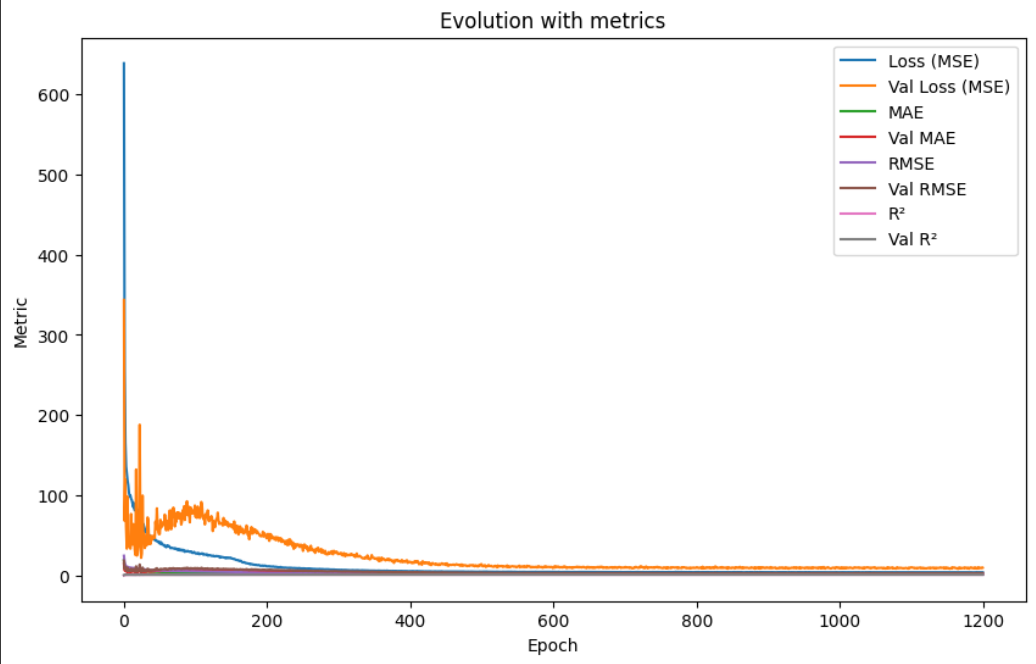

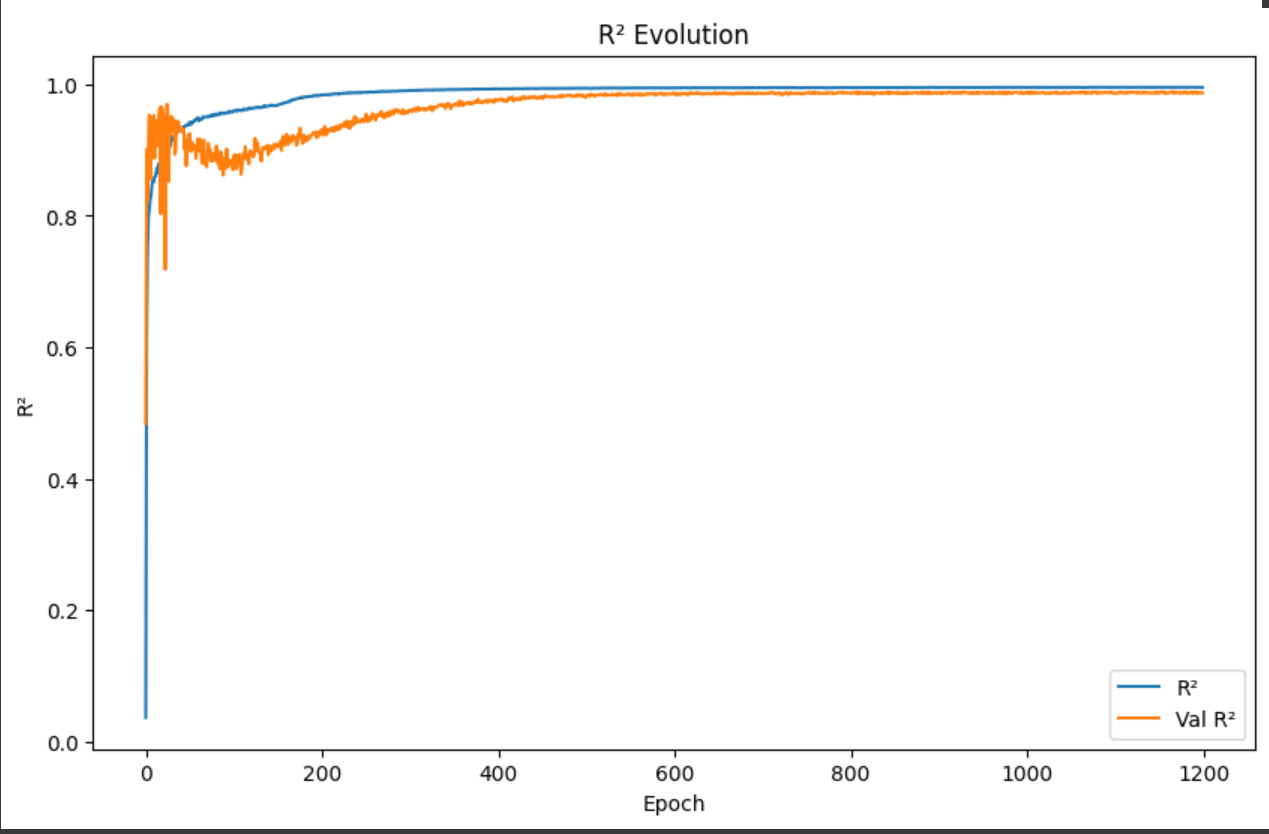

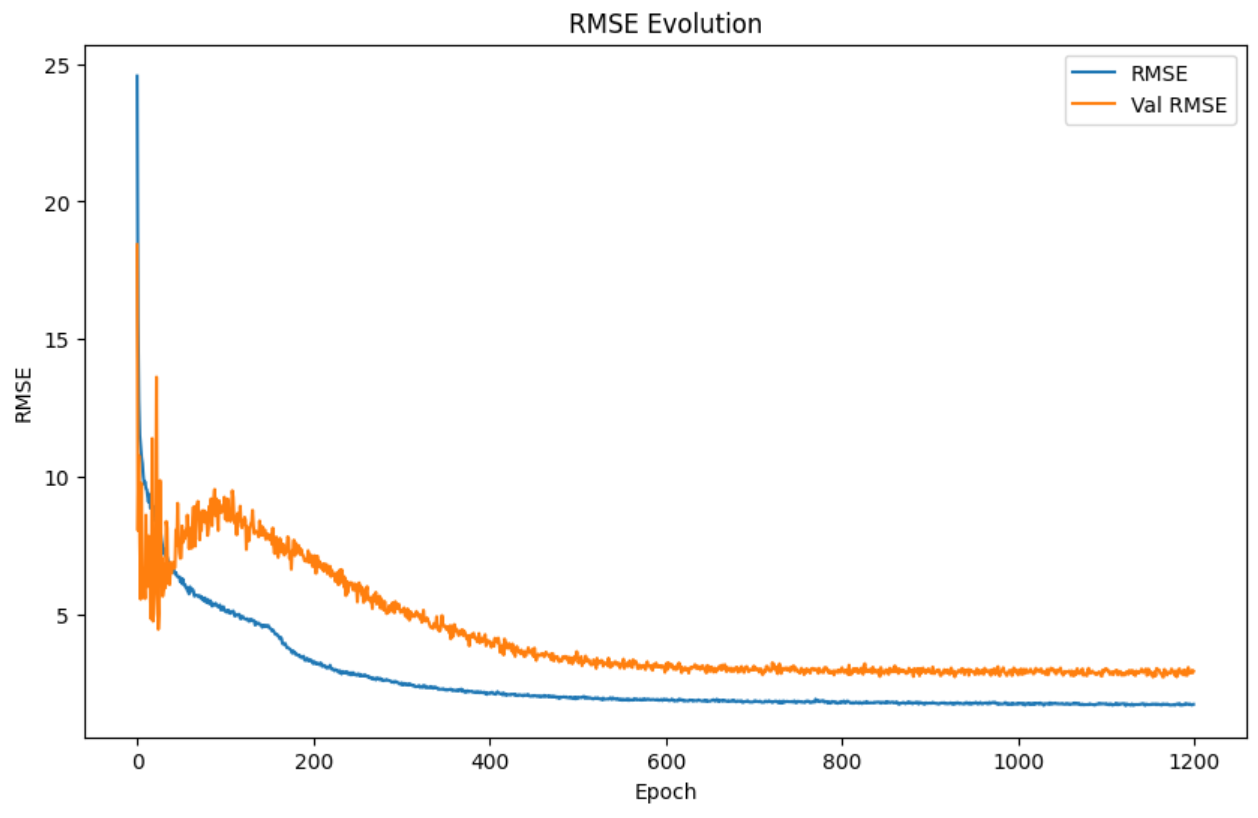

In [ ]:
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))

'''def r2_score_metric(y_true, y_pred):
    SS_res = tf.reduce_sum(tf.square(y_true - y_pred))
    SS_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
    return 1 - SS_res/(SS_tot + tf.keras.backend.epsilon())'''

def r2_score_metric(y_true, y_pred):
    y_true = tf.reshape(y_true, [-1])
    y_pred = tf.reshape(y_pred, [-1])
    SS_res = tf.reduce_sum(tf.square(y_true - y_pred))
    SS_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))

    return 1 - SS_res/(SS_tot + tf.keras.backend.epsilon())

modelo = keras.models.load_model(
    "/content/drive/MyDrive/SIC Proyecto/model.keras",
    custom_objects={"rmse": rmse, "r2_score": r2_score_metric}
)
scaler = joblib.load("/content/drive/MyDrive/SIC Proyecto/scaler5.pkl")


archivos = {
    "Humedad": "/content/drive/MyDrive/SIC Proyecto/humedad(2010-2022).csv",
    "Irradiacion": "/content/drive/MyDrive/SIC Proyecto/Irradiacion(2010-2022).csv",
    "Lluvia": "/content/drive/MyDrive/SIC Proyecto/lluvia(2010-2022).csv",
    "Skintemp": "/content/drive/MyDrive/SIC Proyecto/skintemp(2010-2022).csv",
    "Temp2m": "/content/drive/MyDrive/SIC Proyecto/Temp2m(2010-2022).csv",
    "Viento": "/content/drive/MyDrive/SIC Proyecto/viento(2010-2022).csv"
}

meses = ["JAN", "FEB", "MAR", "APR", "MAY", "JUN",
         "JUL", "AUG", "SEP", "OCT", "NOV", "DEC"]

dfs = []
for nombre, path in archivos.items():
    df = pd.read_csv(path)
    df = df.melt(id_vars=["PARAMETER", "YEAR", "LAT", "LON"],
                 value_vars=meses,
                 var_name="Mes",
                 value_name=nombre)
    df.rename(columns={"YEAR": "Año", "LAT": "Latitud", "LON": "Longitud"}, inplace=True)
    df.drop("PARAMETER", axis=1, inplace=True)
    dfs.append(df)

df_final = dfs[0]
for df in dfs[1:]:
    df_final = df_final.merge(df, on=["Latitud", "Longitud", "Año", "Mes"], how="inner")

mes_map = {"JAN": 1, "FEB": 2, "MAR": 3, "APR": 4, "MAY": 5, "JUN": 6,
           "JUL": 7, "AUG": 8, "SEP": 9, "OCT": 10, "NOV": 11, "DEC": 12}
df_final["Mes"] = df_final["Mes"].map(mes_map)

X = df_final[["Latitud", "Longitud", "Año", "Mes"]]
y = df_final[["Humedad", "Irradiacion", "Lluvia", "Skintemp", "Temp2m", "Viento"]]
_, X_test, _, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_test_escalado = scaler.transform(X_test)

print("Evaluando el modelo...")
resultados = modelo.evaluate(X_test_escalado, y_test, verbose=1)
print(f"Error Cuadrático Medio global (Loss/MSE): {resultados[0]}")
print(f"Error Absoluto Medio global (MAE): {resultados[1]}")
print(f"RMSE global: {resultados[2]}")
print(f"MAPE global: {resultados[3]}")
print(f"R² global: {resultados[4]}")

print("Generando predicciones...")
y_pred = modelo.predict(X_test_escalado)
mse_por_variable = mean_squared_error(y_test, y_pred, multioutput='raw_values')
rmse_por_variable = np.sqrt(mse_por_variable)
r2_por_variable = [r2_score(y_test[col], y_pred[:, i]) for i, col in enumerate(y_test.columns)]
mape_por_variable = [np.mean(np.abs((y_test[col] - y_pred[:, i]) / y_test[col])) * 100 for i, col in enumerate(y_test.columns)]

print("\nMetricas por variable:")
for i, col in enumerate(y_test.columns):
    print(f"{col}:")
    print(f"  - MSE: {mse_por_variable[i]}")
    print(f"  - RMSE: {rmse_por_variable[i]}")
    print(f"  - R²: {r2_por_variable[i]}")
    print(f"  - MAPE: {mape_por_variable[i]}")

'''r2_total = r2_score(y_test, y_pred)
print(f"\nR² total (eficiencia general del modelo): {r2_total}")'''

print("\nGenerando graficos de evaluación...")
fig, axes = plt.subplots(3, 2, figsize=(16, 14))
axes = axes.flatten()

for i, col in enumerate(y_test.columns):
    axes[i].scatter(y_test[col], y_pred[:, i], alpha=0.3)
    min_val = min(y_test[col].min(), y_pred[:, i].min())
    max_val = max(y_test[col].max(), y_pred[:, i].max())
    axes[i].plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)

    axes[i].set_title(f'{col}: R² = {r2_por_variable[i]:.3f}, RMSE = {rmse_por_variable[i]:.3f}')
    axes[i].set_xlabel('Valor Real')
    axes[i].set_ylabel('Valor Predicho')
    axes[i].grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.savefig("/content/drive/MyDrive/SIC Proyecto/evaluacion_modelo_mejorado.png")
plt.show()

print("\nEjemplo de predicción para un punto específico:")
nueva_entrada = pd.DataFrame({
    "Latitud": [18.95],
    "Longitud": [-96.51],
    "Año": [2025],
    "Mes": [10]
})
nueva_entrada_escalada = scaler.transform(nueva_entrada)
prediccion = modelo.predict(nueva_entrada_escalada)
print("Predicción para las coordenadas (18.7897, -95.9645) en Marzo 2025:")
for i, col in enumerate(y.columns):
    print(f"{col}: {prediccion[0][i]}")

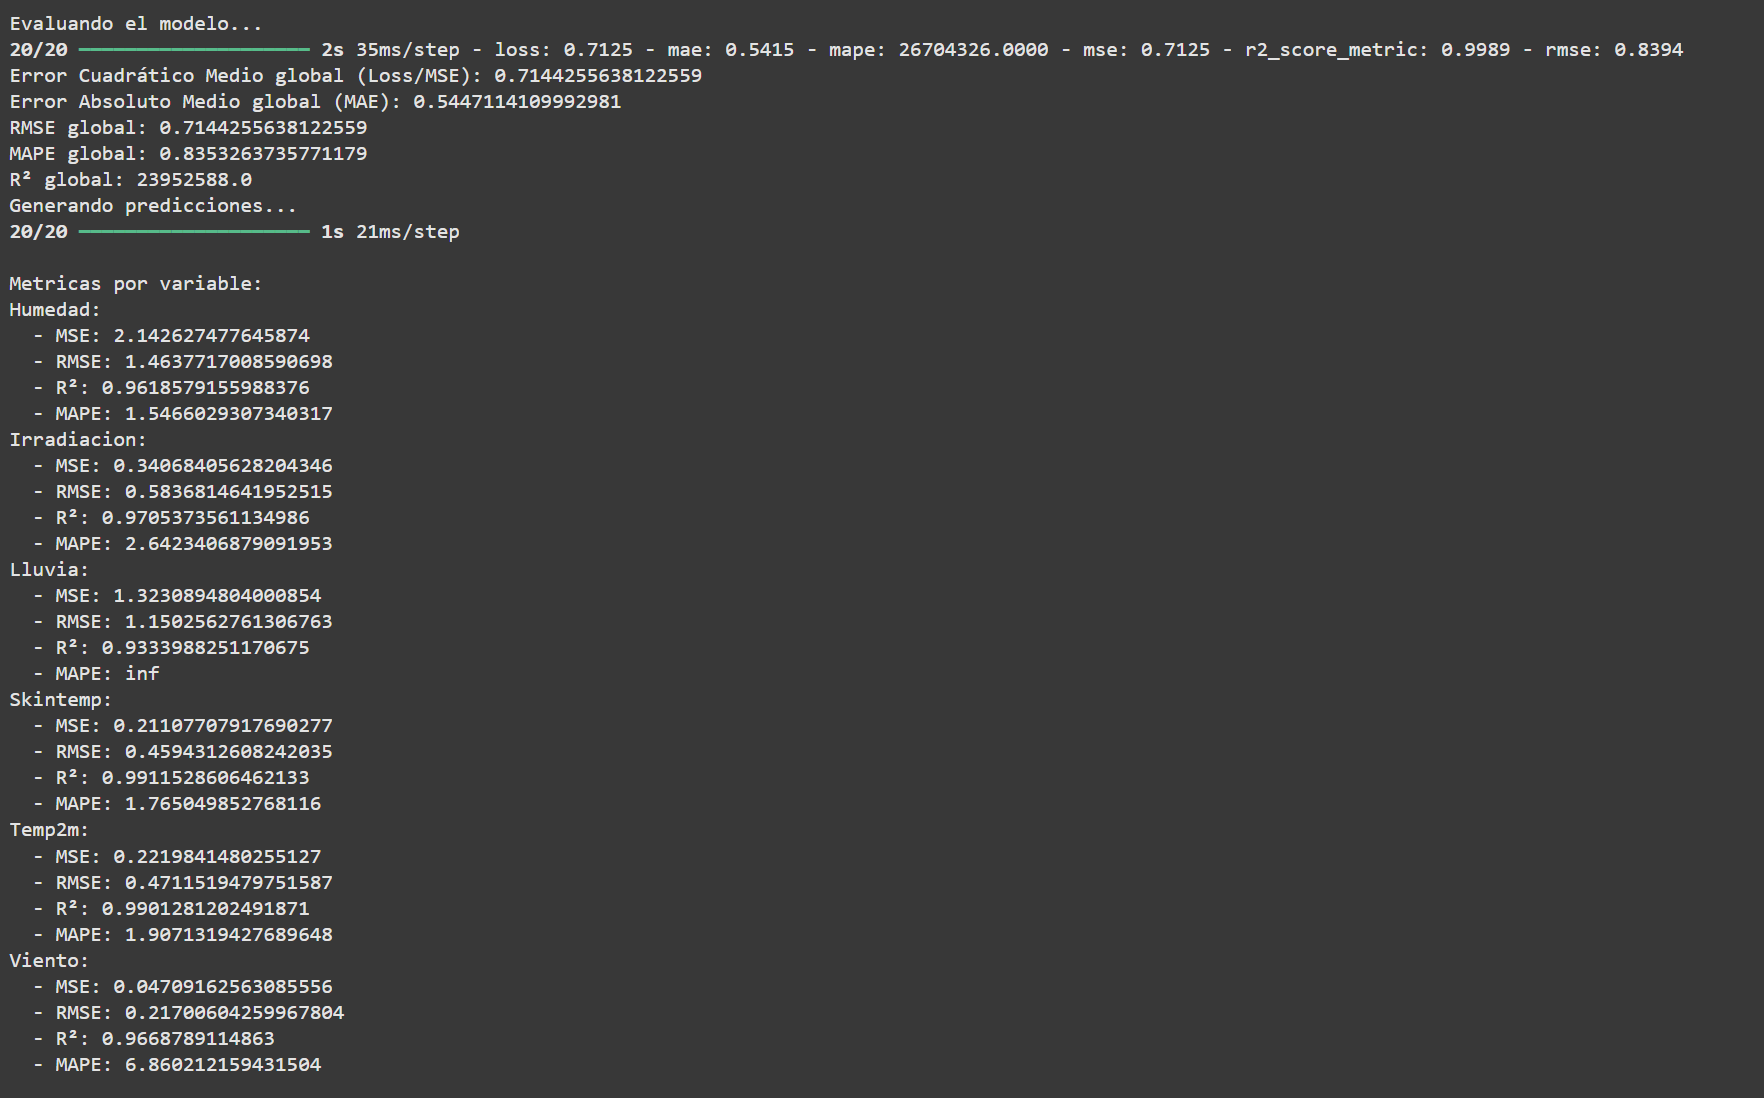

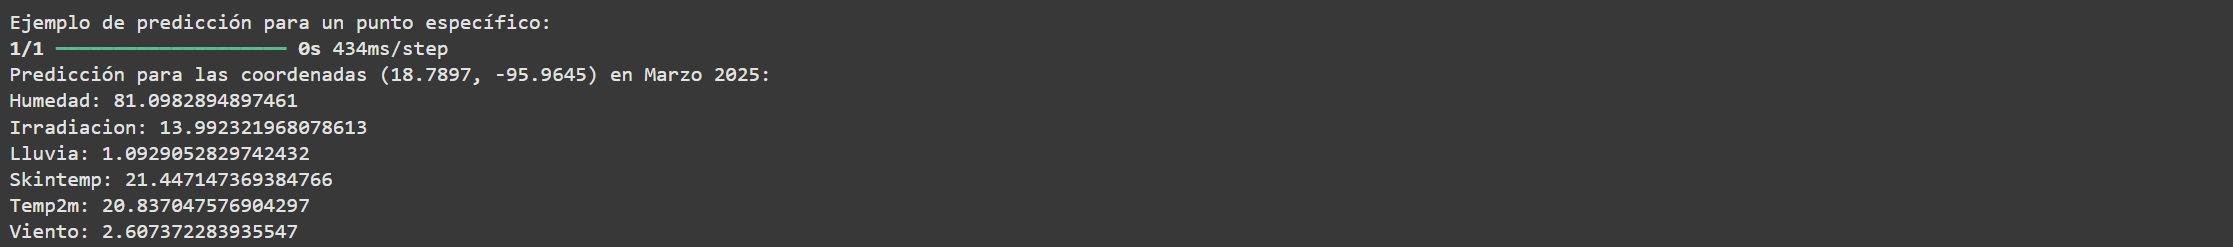

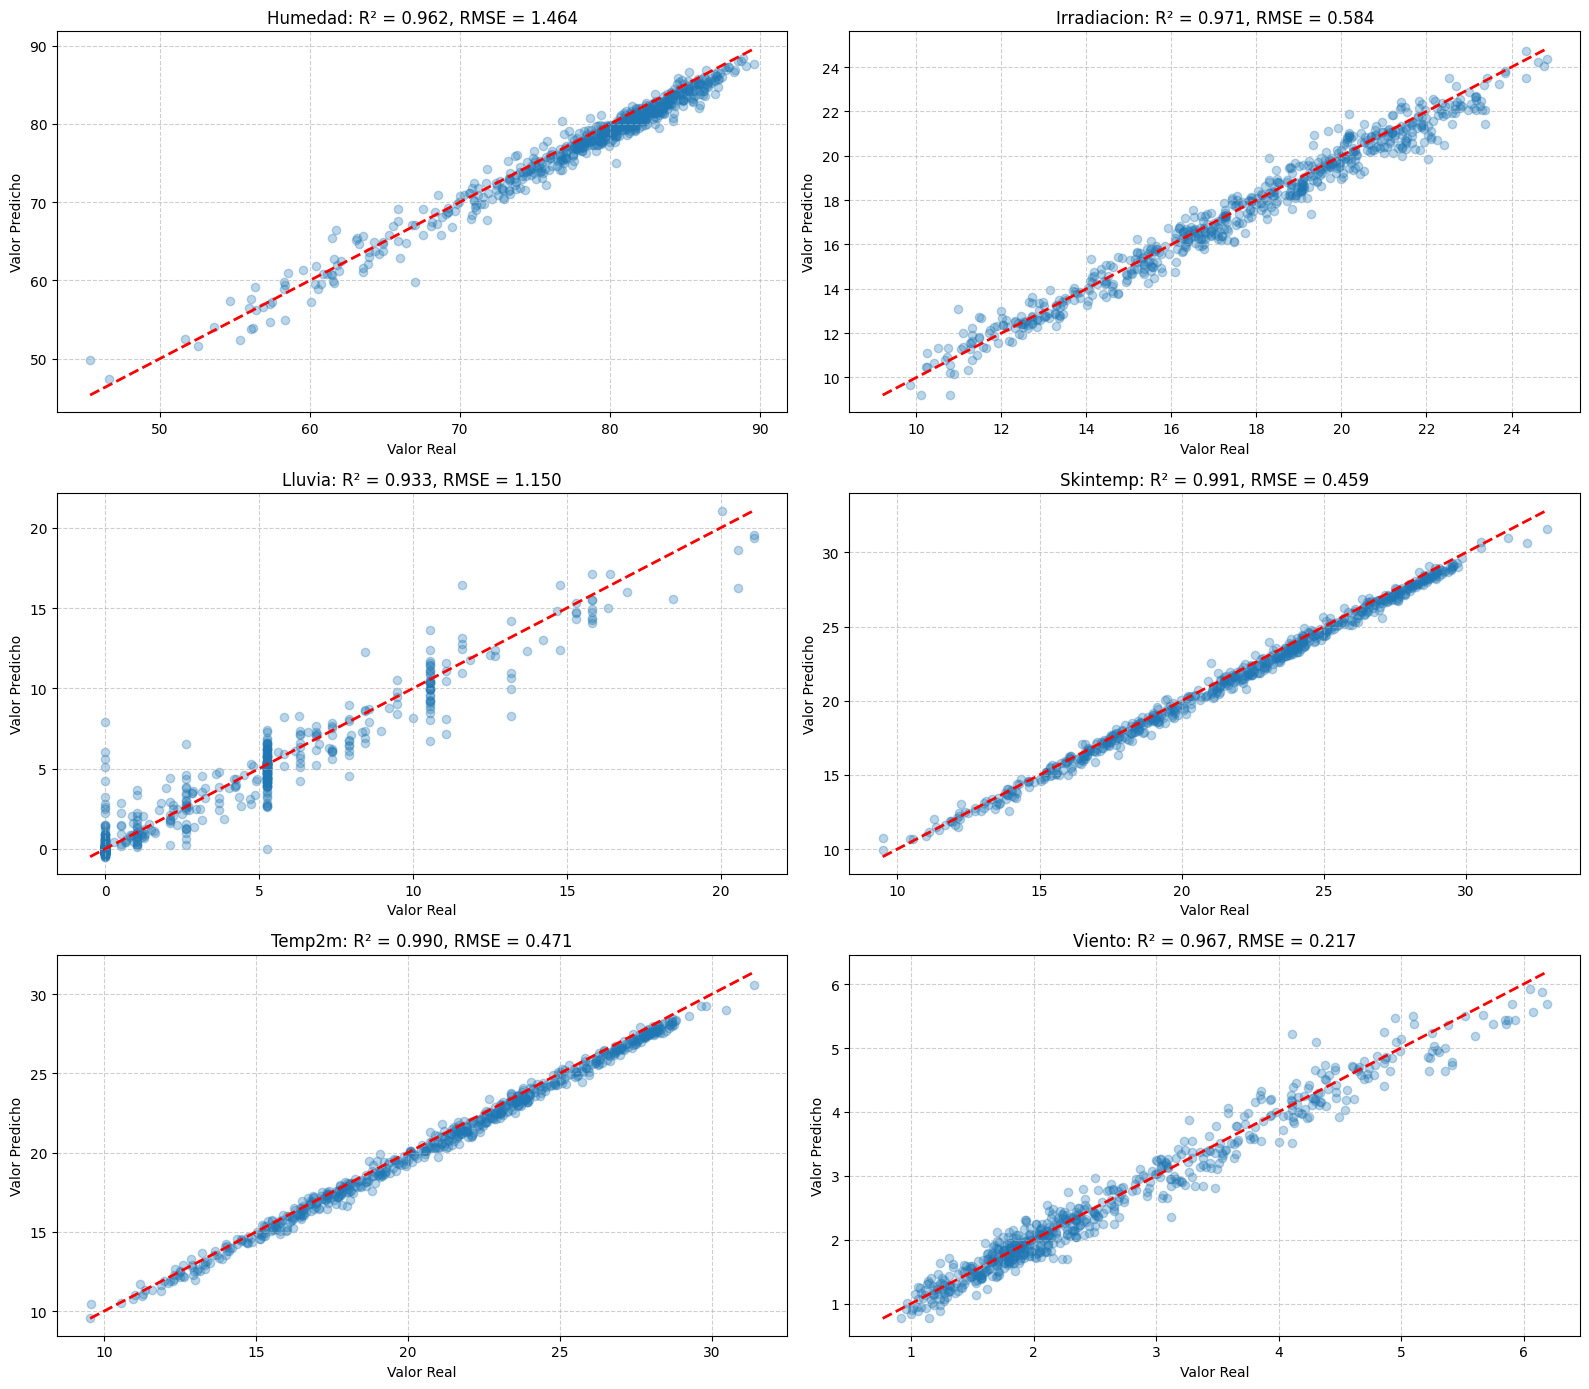